Found 47 files belonging to 3 classes.
Found 14 files belonging to 3 classes.
Epoch 1/5
2/2 ━━━━━━━━━━━━━━━━━━━━ 8s 2s/step - accuracy: 0.2553 - loss: 1.2664 - val_accuracy: 0.2857 - val_loss: 1.2027
Epoch 2/5
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 338ms/step - accuracy: 0.3830 - loss: 1.1318 - val_accuracy: 0.2143 - val_loss: 1.3662
Epoch 3/5
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 322ms/step - accuracy: 0.4255 - loss: 1.1500 - val_accuracy: 0.2143 - val_loss: 1.3438
Epoch 4/5
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 338ms/step - accuracy: 0.5106 - loss: 1.0731 - val_accuracy: 0.2857 - val_loss: 1.2323
Epoch 5/5
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 341ms/step - accuracy: 0.4894 - loss: 0.9836 - val_accuracy: 0.3571 - val_loss: 1.1883



Prediction Results:

Testing high risk image:
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
high: 12.04%
medium: 19.84%
low: 68.12%

Testing medium risk image:
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step
high: 9.96%
medium: 42.51%
low: 47.54%

Testing low risk image:
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step
high: 50.98%
medium: 27.14%
low: 21.88%


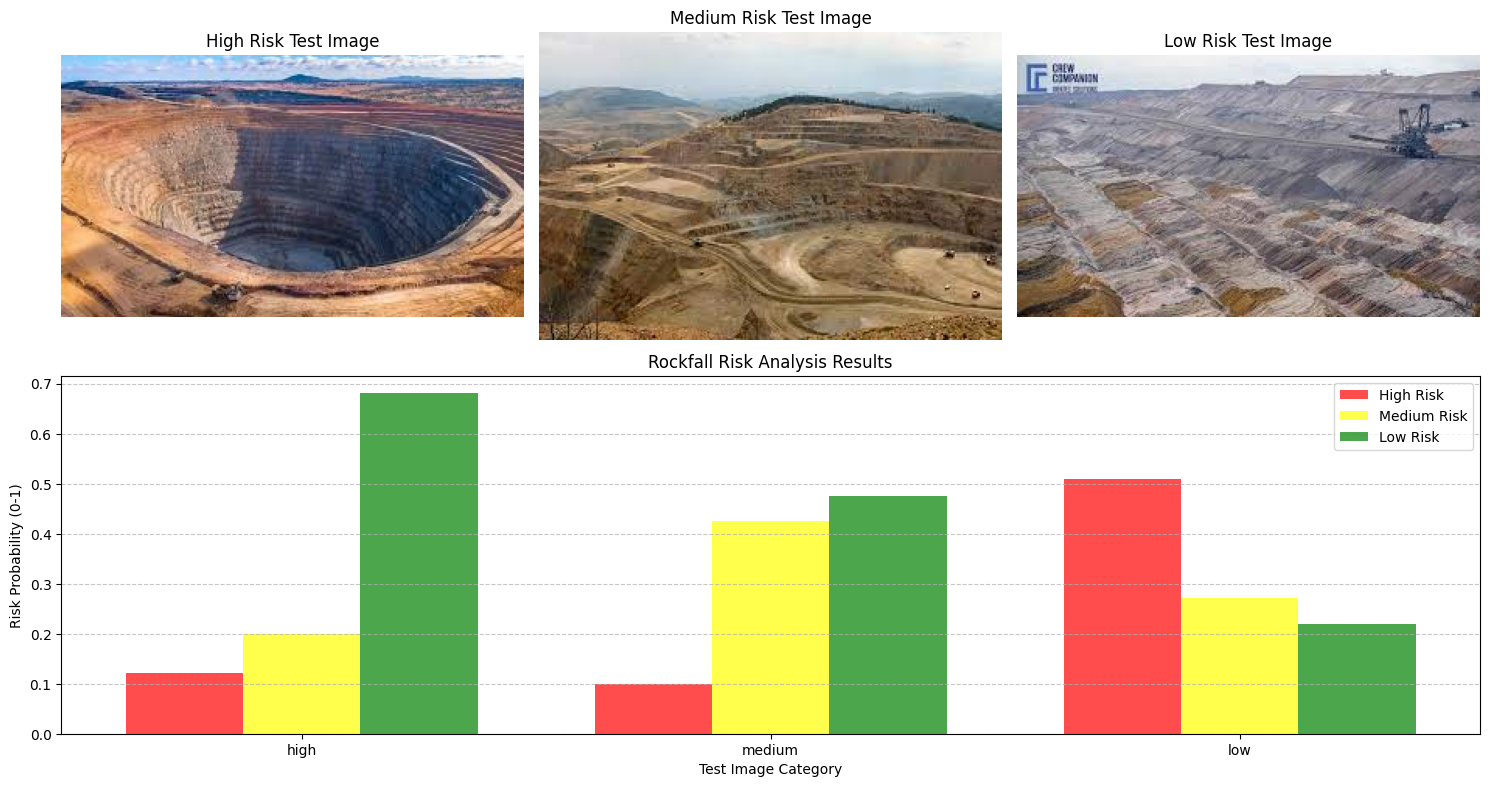

In [1]:
import tensorflow as tf
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras import layers, models
import matplotlib.pyplot as plt
import numpy as np

train_ds = image_dataset_from_directory(
    'data/train',
    image_size=(224, 224),
    batch_size=32,
    label_mode='categorical'
)

val_ds = image_dataset_from_directory(
    'data/test',
    image_size=(224, 224),
    batch_size=32,
    label_mode='categorical'
)

base_model = tf.keras.applications.MobileNetV2(
    input_shape=(224, 224, 3),
    include_top=False,
    weights='imagenet'
)
base_model.trainable = False

model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(3, activation='softmax')
])

model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

history = model.fit(train_ds, validation_data=val_ds, epochs=5)

model.save('models/rockfall_model.h5')

def predict_image(image_path):
    img = tf.keras.preprocessing.image.load_img(
        image_path, target_size=(224, 224)
    )
    img_array = tf.keras.preprocessing.image.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)
    class_names = ['high', 'medium', 'low']
    result = {class_names[i]: float(predictions[0][i]) for i in range(len(class_names))}
    return result

test_images = {
    'high': 'data/test/high/download.jpg',
    'medium': 'data/test/medium/images (1).jpg',
    'low': 'data/test/low/download.jpg'
}

print("\nPrediction Results:")
prediction_results = {}
for category, img_path in test_images.items():
    print(f"\nTesting {category} risk image:")
    result = predict_image(img_path)
    prediction_results[category] = result
    for risk_level, probability in result.items():
        print(f"{risk_level}: {probability:.2%}")

plt.figure(figsize=(15, 8))

for idx, (risk_level, image_path) in enumerate(test_images.items()):
    plt.subplot(2, 3, idx + 1)
    img = tf.keras.preprocessing.image.load_img(image_path)
    plt.imshow(img)
    plt.title(f'{risk_level.title()} Risk Test Image')
    plt.axis('off')

plt.subplot(2, 1, 2)
x = np.arange(len(test_images))
bar_width = 0.25

risk_levels = ['high', 'medium', 'low']
bar_colors = ['red', 'yellow', 'green']

for i, (risk, color) in enumerate(zip(risk_levels, bar_colors)):
    probabilities = [prediction_results[img_type][risk]
                    for img_type in test_images.keys()]
    plt.bar(x + i*bar_width, probabilities, bar_width,
            label=f'{risk.title()} Risk', color=color, alpha=0.7)

plt.xlabel('Test Image Category')
plt.ylabel('Risk Probability (0-1)')
plt.title('Rockfall Risk Analysis Results')
plt.xticks(x + bar_width, list(test_images.keys()))
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()
